In [1]:
import requests
from io import BytesIO
from zipfile import ZipFile
import torch
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
from torch import optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import copy
from tqdm.notebook import tqdm
import seaborn as sns
from sklearn.metrics import classification_report
!pip install torchviz
from torchviz import make_dot


  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
  Using cached 

## Download the Dataset

In [2]:
#Download the Dataset

dataset_link = 'https://universe.roboflow.com/ds/34oBZCp0Y9?key=M2AxU6iuig'
response = requests.get(dataset_link)
zip_file = ZipFile(BytesIO(response.content))

extracted_folder = '/dataset'
zip_file.extractall(extracted_folder)

## Pre-processing Dataset




In [3]:
transform_train = transforms.Compose(
    [
        transforms.Resize((224,224)),
        # using such random flips, helps to increase variability in your training data, which can prevent overfitting and improve the model's ability to generalize to unseen data
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.RandomRotation(30),
        transforms.ToTensor(),
        transforms.Normalize(mean = [0.485, 0.456, 0.406],std = [0.229, 0.224, 0.225])
   ]
)

transform_test = transforms.Compose(
    [
         #all the images are currently 224 pixels but we can rezie later according to model accuracy to see if it makes any difference
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(mean = [0.485, 0.456, 0.406],std = [0.229, 0.224, 0.225])
   ]
)

In [4]:
# Define object of the Train, Validation, and Test dataset.

train_dataset = torchvision.datasets.ImageFolder("/dataset/train", transform=transform_train)
train_dataset.transform

val_dataset = torchvision.datasets.ImageFolder("/dataset/valid", transform=transform_test)
val_dataset.transform

test_dataset = torchvision.datasets.ImageFolder("/dataset/test", transform=transform_test)
test_dataset.transform

Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

## Creating DataLoaders

In [5]:
# train set has 2076 images so can use greater batch size but valid and test have 531 and 231 so must use smaller batch size or there will be overfitting
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 256, shuffle = True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size = 64, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 64, shuffle = True)

In [6]:
# Print shape of Dataset
for key, value in {'Training data': train_loader, "Validation data": val_loader}.items():
    for X, y in value:
        print(f"{key}:")
        print(f"Shape of X : {X.shape}")
        print(f"Shape of y: {y.shape} {y.dtype}\n")
        break

Training data:
Shape of X : torch.Size([256, 3, 224, 224])
Shape of y: torch.Size([256]) torch.int64

Validation data:
Shape of X : torch.Size([64, 3, 224, 224])
Shape of y: torch.Size([64]) torch.int64



## Model Architectures

In [9]:
def findConv2dOutShape(hin,win,conv,pool=2):
    kernel_size = conv.kernel_size
    stride=conv.stride
    padding=conv.padding
    dilation=conv.dilation

    hout=np.floor((hin+2*padding[0]-dilation[0]*(kernel_size[0]-1)-1)/stride[0]+1)
    wout=np.floor((win+2*padding[1]-dilation[1]*(kernel_size[1]-1)-1)/stride[1]+1)

    if pool:
        hout/=pool
        wout/=pool
    return int(hout),int(wout)

In [10]:
# architecture of model

class Classification_Diabetic_Retinopathy(nn.Module):

    def __init__(self, params):

        super(Classification_Diabetic_Retinopathy, self).__init__()

        Cin,Hin,Win = params["shape_in"]
        init_f = params["initial_filters"]
        num_fc1 = params["num_fc1"]
        num_classes = params["num_classes"]
        self.dropout_rate = params["dropout_rate"]

        # CNN Layers

        self.conv1 = nn.Conv2d(Cin, init_f, kernel_size=3)
        h,w=findConv2dOutShape(Hin,Win,self.conv1)

        self.conv2 = nn.Conv2d(init_f, 2*init_f, kernel_size=3)
        h,w=findConv2dOutShape(h,w,self.conv2)

        self.conv3 = nn.Conv2d(2*init_f, 4*init_f, kernel_size=3)
        h,w=findConv2dOutShape(h,w,self.conv3)

        self.conv4 = nn.Conv2d(4*init_f, 8*init_f, kernel_size=3)
        h,w=findConv2dOutShape(h,w,self.conv4)

        self.num_flatten=h*w*8*init_f
        self.fc1 = nn.Linear(self.num_flatten, num_fc1)
        self.fc2 = nn.Linear(num_fc1, num_classes)

    def forward(self,X):

        X = F.relu(self.conv1(X));
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv3(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv4(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, self.num_flatten)
        X = F.relu(self.fc1(X))
        X = F.dropout(X, self.dropout_rate)
        X = self.fc2(X)
        return F.log_softmax(X, dim=1)

## Instantiate Model

In [ ]:
params_model={
        "shape_in": (3,224,224),
        "initial_filters": 8,
        "num_fc1": 100,
        "dropout_rate": 0.15,
        "num_classes": 5}

CNN_model = Classification_Diabetic_Retinopathy(params_model)

In [ ]:
# define computation hardware approach (GPU/CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
CNN_model = CNN_model.to(device)

## Visualise Model

In [ ]:
# Model Summary
summary(CNN_model, input_size=(3, 224, 224),device=device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 222, 222]             224
            Conv2d-2         [-1, 16, 109, 109]           1,168
            Conv2d-3           [-1, 32, 52, 52]           4,640
            Conv2d-4           [-1, 64, 24, 24]          18,496
            Linear-5                  [-1, 100]         921,700
            Linear-6                    [-1, 5]             505
Total params: 946,733
Trainable params: 946,733
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 5.40
Params size (MB): 3.61
Estimated Total Size (MB): 9.59
----------------------------------------------------------------


In [ ]:
#visualise the model in an image form

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
CNN_model.to(device)

input_tensor = torch.randn(1, 3, 224, 224, device=device)

dot = make_dot(CNN_model(input_tensor), params=dict(CNN_model.named_parameters()))

dot.render("CNN_model_visualization", format="pdf")

'CNN_model_visualization.pdf'

## Define Optimizer and Loss Function

In [ ]:
loss_func = nn.CrossEntropyLoss()

In [ ]:
opt = optim.Adam(CNN_model.parameters(), lr=0.001)

lr_scheduler = ReduceLROnPlateau(opt, mode='min',factor=0.5, patience=20,verbose=1)

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


## Train Model

In [ ]:
# Function to get the learning rate
def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']

# Function to compute the loss value per batch of data
def loss_batch(loss_func, output, target, opt=None):

    loss = loss_func(output, target) # get loss
    pred = output.argmax(dim=1, keepdim=True) # Get Output Class
    metric_b=pred.eq(target.view_as(pred)).sum().item() # get performance metric

    if opt is not None:
        opt.zero_grad()
        loss.backward()
        opt.step()

    return loss.item(), metric_b

# Compute the loss value & performance metric for epoch
def loss_epoch(model,loss_func,dataset_dl,opt=None):

    run_loss=0.0
    t_metric=0.0
    len_data=len(dataset_dl.dataset)

    for xb, yb in dataset_dl:
        xb=xb.to(device)
        yb=yb.to(device)
        output=model(xb)
        loss_b,metric_b=loss_batch(loss_func, output, yb, opt)
        run_loss+=loss_b

        if metric_b is not None:
            t_metric+=metric_b

    loss=run_loss/float(len_data)
    metric=t_metric/float(len_data)

    return loss, metric

In [ ]:
def train_val(model, params, verbose=False):

    # Get the parameters
    epochs=params["epochs"]
    loss_func=params["f_loss"]
    opt=params["optimiser"]
    train_dl=params["train"]
    val_dl=params["val"]
    lr_scheduler=params["lr_change"]
    weight_path=params["weight_path"]

    loss_history={"train": [],"val": []}
    metric_history={"train": [],"val": []}
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss=float('inf')


    for epoch in tqdm(range(epochs)):

        # Get the Learning Rate
        current_lr = get_lr(opt)
        if(verbose):
            print('Epoch {}/{}, current lr={}'.format(epoch, epochs - 1, current_lr))




        model.train()
        train_loss, train_metric = loss_epoch(model,loss_func,train_dl,opt)

        loss_history["train"].append(train_loss)
        metric_history["train"].append(train_metric)


# Evaluate Model Process

        model.eval()
        with torch.no_grad():
            val_loss, val_metric = loss_epoch(model,loss_func,val_dl)

        if(val_loss < best_loss):
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())

            torch.save(model.state_dict(), weight_path)
            if(verbose):
                print("Copied best model weights!")

        loss_history["val"].append(val_loss)
        metric_history["val"].append(val_metric)

        lr_scheduler.step(val_loss)
        if current_lr != get_lr(opt):
            if(verbose):
                print("Loading best model weights!")
            model.load_state_dict(best_model_wts)

        if(verbose):
            print(f"train loss: {train_loss:.6f}, dev loss: {val_loss:.6f}, accuracy: {100*val_metric:.2f}")
            print("-"*10)

    model.load_state_dict(best_model_wts)

    return model, loss_history, metric_history

In [ ]:
params_train={
 "train": train_loader,"val": val_loader,
 "epochs": 80,
 "optimiser": optim.Adam(CNN_model.parameters(),lr=0.001),
 "lr_change": ReduceLROnPlateau(opt, mode='min',factor=0.5, patience=20,verbose=1),
 "f_loss": nn.CrossEntropyLoss(),
 "weight_path": "weights_run1.pt",
}

# train and validate the model
model,loss_hist_m,metric_hist_m = train_val(CNN_model,params_train)

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


  0%|          | 0/80 [00:00<?, ?it/s]

## Generate Convergance Plots

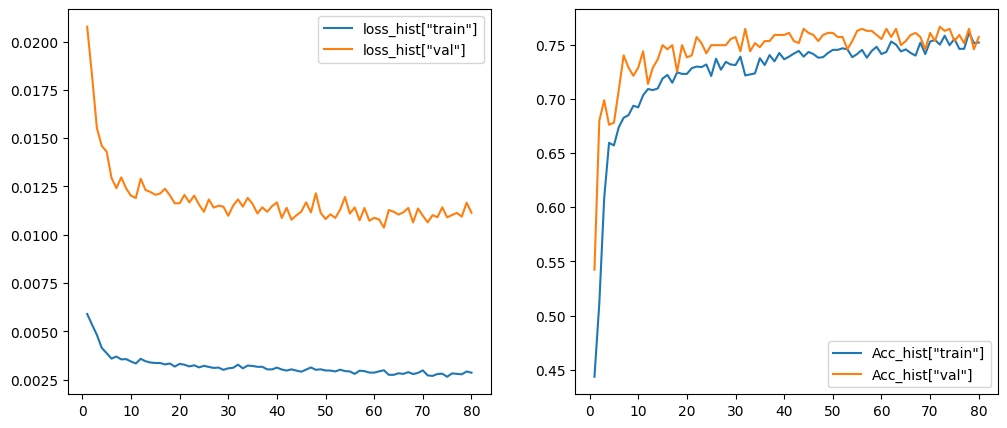

In [ ]:
epochs=params_train["epochs"]
fig,ax = plt.subplots(1,2,figsize=(12,5))

sns.lineplot(x=[*range(1,epochs+1)],y=loss_hist_m["train"],ax=ax[0],label='loss_hist["train"]')
sns.lineplot(x=[*range(1,epochs+1)],y=loss_hist_m["val"],ax=ax[0],label='loss_hist["val"]')
sns.lineplot(x=[*range(1,epochs+1)],y=metric_hist_m["train"],ax=ax[1],label='Acc_hist["train"]')
sns.lineplot(x=[*range(1,epochs+1)],y=metric_hist_m["val"],ax=ax[1],label='Acc_hist["val"]')

plt.savefig("CNN_model_convergence_hist_plot_run1.png")

## Classification Report for Training Dataset

In [14]:
def ture_and_pred_data(val_loader, model):
    i = 0
    y_true = []
    y_pred = []
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.numpy()
        outputs = model(images)
        _, pred = torch.max(outputs.data, 1)
        pred = pred.detach().cpu().numpy()

        y_true = np.append(y_true, labels)
        y_pred = np.append(y_pred, pred)

    return y_true, y_pred

In [15]:
# Classification Report for Model based on Train Set

y_true, y_pred = ture_and_pred_data(train_loader, CNN_model)
print(classification_report(y_true, y_pred), '\n\n')

NameError: name 'CNN_model' is not defined

## Classification Report for Validation Dataset

In [ ]:
 # Classification Report for Model based on Validation Set

y_true, y_pred = ture_and_pred_data(val_loader, CNN_model)
print(classification_report(y_true, y_pred), '\n\n')

              precision    recall  f1-score   support

         0.0       0.44      0.46      0.45        57
         1.0       0.59      0.74      0.66       138
         2.0       0.93      0.97      0.95       286
         3.0       0.00      0.00      0.00        31
         4.0       0.00      0.00      0.00        19

    accuracy                           0.76       531
   macro avg       0.39      0.43      0.41       531
weighted avg       0.70      0.76      0.73       531
 




/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Save the Model

In [ ]:
torch.save(CNN_model, "CNN_Model_run1.pt")

## Evaluate model on Test Dataset

In [16]:
# Load the pretrained model
model = torch.load("/content/CNN_model_run1.pt") #change to your file path

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [ ]:
# This cell is repeated for running the pretrained model and making the predictions on the test set
def ture_and_pred_data(val_loader, model):
    i = 0
    y_true = []
    y_pred = []
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.numpy()
        outputs = model(images)
        _, pred = torch.max(outputs.data, 1)
        pred = pred.detach().cpu().numpy()

        y_true = np.append(y_true, labels)
        y_pred = np.append(y_pred, pred)

    return y_true, y_pred

In [17]:
# Iterate over the test loader for prediction

with torch.no_grad():
    for images, _ in test_loader:

        images = images.to(device)
        output = model(images)
        probabilities = torch.softmax(output, dim=1)
        predicted_classes = torch.argmax(probabilities, dim=1)

        for predicted_class in predicted_classes:
            print("Predicted class:", predicted_class.item())

Predicted class: 2
Predicted class: 1
Predicted class: 1
Predicted class: 1
Predicted class: 1
Predicted class: 0
Predicted class: 2
Predicted class: 2
Predicted class: 1
Predicted class: 1
Predicted class: 0
Predicted class: 2
Predicted class: 0
Predicted class: 2
Predicted class: 2
Predicted class: 1
Predicted class: 1
Predicted class: 2
Predicted class: 1
Predicted class: 1
Predicted class: 2
Predicted class: 1
Predicted class: 1
Predicted class: 1
Predicted class: 1
Predicted class: 2
Predicted class: 2
Predicted class: 1
Predicted class: 0
Predicted class: 1
Predicted class: 1
Predicted class: 2
Predicted class: 1
Predicted class: 0
Predicted class: 2
Predicted class: 2
Predicted class: 2
Predicted class: 2
Predicted class: 2
Predicted class: 2
Predicted class: 2
Predicted class: 0
Predicted class: 1
Predicted class: 2
Predicted class: 1
Predicted class: 2
Predicted class: 2
Predicted class: 1
Predicted class: 2
Predicted class: 2
Predicted class: 2
Predicted class: 2
Predicted cl

In [18]:
## Classification Report for Model based on Test set

y_true, y_pred = ture_and_pred_data(test_loader, model)
print(classification_report(y_true, y_pred), '\n\n')

              precision    recall  f1-score   support

         0.0       0.50      0.40      0.44        20
         1.0       0.60      0.83      0.70        65
         2.0       0.91      0.96      0.93       118
         3.0       0.00      0.00      0.00        20
         4.0       0.00      0.00      0.00         8

    accuracy                           0.76       231
   macro avg       0.40      0.44      0.42       231
weighted avg       0.68      0.76      0.71       231
 




/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
